# Generative Xrays

Ref: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [ ]:
from google.colab import drive, files

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy
import plotly.express as px

In [ ]:
# seed data
seed = 10
torch.manual_seed(seed)

In [ ]:
# check if gpu is being used
# use A100 (newer) or V100
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


# Check if a GPU is available
# assign device to GPU or CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

Fri Dec  8 21:35:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
# change this to your path to your kaggle.json in your google drive
! cp ./drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d nih-chest-xrays/data
! unzip nih-chest-xrays.zip

100% 42.0G/42.0G [37:57<00:00, 21.6MB/s]
100% 42.0G/42.0G [37:57<00:00, 19.8MB/s]
unzip:  cannot find or open nih-chest-xrays.zip, nih-chest-xrays.zip.zip or nih-chest-xrays.zip.ZIP.


In [ ]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: images_012/images/00028897_016.png  
  inflating: images_012/images/00028897_017.png  
  inflating: images_012/images/00028897_018.png  
  inflating: images_012/images/00028897_019.png  
  inflating: images_012/images/00028897_020.png  
  inflating: images_012/images/00028898_000.png  
  inflating: images_012/images/00028899_000.png  
  inflating: images_012/images/00028899_001.png  
  inflating: images_012/images/00028899_002.png  
  inflating: images_012/images/00028900_000.png  
  inflating: images_012/images/00028901_000.png  
  inflating: images_012/images/00028901_001.png  
  inflating: images_012/images/00028902_000.png  
  inflating: images_012/images/00028902_001.png  
  inflating: images_012/images/00028902_002.png  
  inflating: images_012/images/00028902_003.png  
  inflating: images_012/images/00028902_004.png  
  inflating: images_012/images/00028902_005.png  
  inflating: images_012/images/00028902_006.png  

## Data Cleaning

### Move image folders into one folder for data loader

1. Create a new folder called images
2. Run the code below and specify which source directories you would like to move into images

This concatenates the training data folders per user requirements

In [ ]:
import shutil
import os


# Source directories
source_directories = [ "images_001/images", "images_002/images", "images_003/images", "images_004/images", "images_005/images", "images_006/images"]#, "images_007/images", "images_008/images"]

# Destination directory
destination_directory = "images"

for source_dir in source_directories:
    files = os.listdir(source_dir)


    for file in files:

        source_path = os.path.join(source_dir, file)
        destination_path = os.path.join(destination_directory, file)

        shutil.move(source_path, destination_path)

print("Files moved successfully.")

Files moved successfully.


### Dataframe for CXR images

In [ ]:
import os
df = pd.read_csv('Data_Entry_2017.csv')
df = df.iloc[0:len(os.listdir('images'))]
df = df.reset_index()
print(len(df))
df.head()

# 1336_0000 images002
# delimited by |

54999


index       Image Index          Finding Labels  Follow-up #  Patient ID  \
0      0  00000001_000.png            Cardiomegaly            0           1   
1      1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2      2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3      3  00000002_000.png              No Finding            0           2   
4      4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

## Dataset and Dataloader set up

### Create NIH dataset class

In [ ]:
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

labels_dict = {

'Atelectasis': 0,
'Consolidation': 1,
'Infiltration': 2,
'Pneumothorax': 3,
'Edema': 4,
'Emphysema': 5,
'Fibrosis': 6,
'Effusion': 7,
'Pneumonia': 8,
'Pleural_thickening': 9,
'Cardiomegaly': 10,
'Nodule': 11,
'Mass': 12,
'Hernia': 13,
'No Finding': 14

}

class NIHDataset(Dataset):

  def __init__(self, imgDir, target_df, transform=None, target_transform=None):
    self.df = target_df
    self.imgDir = imgDir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    path = self.df.iloc[idx]["Image Index"]
    img_path = f'{self.imgDir}/{path}'
    image = read_image(img_path, mode=ImageReadMode.RGB)
    label = self.df.iloc[idx]["Finding Labels"]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

### Create and sample dataloader

torch.Size([3, 64, 64])


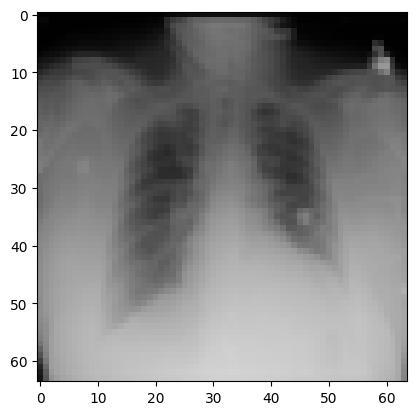

Label: No Finding
torch.Size([3, 64, 64])


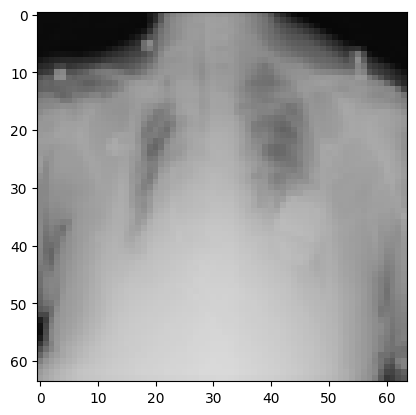

Label: Pleural_Thickening
torch.Size([3, 64, 64])


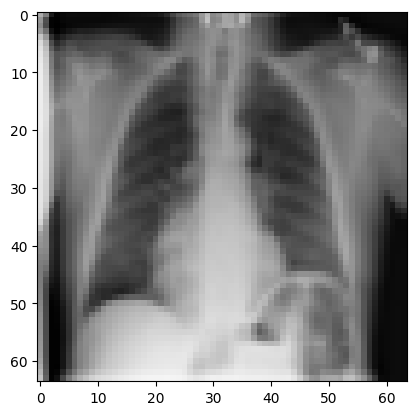

Label: No Finding
torch.Size([3, 64, 64])


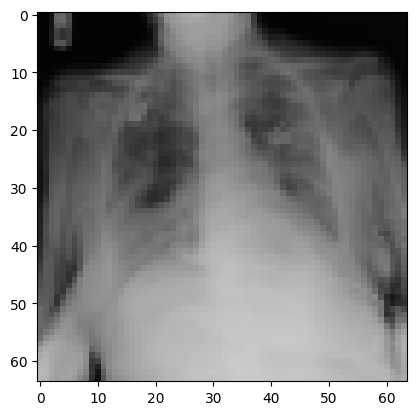

Label: No Finding


In [ ]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((64,64), antialias=True), # resized to 64 for GPU constraints and based on GANs input

])
imgDir = './images'
train_dataset = NIHDataset(imgDir, df,transform=transform)
batch_size = 256 # IMPORTANT: change this hyperparameter as fit
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
train_features, train_labels = next(iter(train_dataloader))

for i in range(4):
  print(train_features[i].shape)
  img = train_features[i].squeeze()
  img = img.numpy().transpose((1, 2, 0))
  label = train_labels[i]
  plt.imshow(img)
  plt.show()
  print(f"Label: {label}")
# 1024 x 1024

## GANs model

In [ ]:
# normalizes initial weights for Discriminator and Generator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
input_size = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

class myGenerator(nn.Module):
    def __init__(self, input_size):
        super(myGenerator, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( input_size, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )


    def forward(self, x):
        return self.main(x)

class myDiscriminator(nn.Module):
    def __init__(self,):
        super(myDiscriminator, self).__init__()

        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
# RERUN THIS BEFORE EVERY RUN

gen = myGenerator(input_size)
gen.to(device)
gen.apply(weights_init)
gen

myGenerator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


In [ ]:
# RERUN THIS BEFORE EVERY RUN
disc = myDiscriminator()
disc.to(device)
disc.apply(weights_init)
disc

myDiscriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

### Train

In [ ]:
criterion = F.binary_cross_entropy

real_label = 1
fake_label = 0
lr = 0.001
optimizerDisc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999) )
optimizerGen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# Early Stopping class
from sklearn.metrics import accuracy_score
import itertools
class EarlyStopping():
    def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
        """
        Stops the model if improvement is negligible.

        After a certain number of epochs (patience), if the loss doesn't
        improve by (delta) then the model will stop
        training by setting the early_stop flag to True
        and save the model to (path)
        """

        self.patience = patience # how many epochs to wait for improvement
        self.delta = delta # threshold for improvement (if doesn't improve by this much by "n" epochs, stop training)
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# clear GPU cache (RUN THIS BEFORE EVERY TRAINING RUN)

import torch
import torch.nn as nn

import gc
del gen
del disc
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
img_list = []
G_losses = []
D_losses = []

import torchvision.utils as vutils

num_epochs = 10

# init Early Stopping
early_stopping = EarlyStopping(patience=5, delta=0.001, verbose=True, path="GANs.pth")

noise_input = torch.randn(16, input_size,1,1 ).to(device)

for epoch in range(num_epochs):
  epoch_loss = []
  for i, data in enumerate(train_dataloader):

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    disc.zero_grad()
    # Format batch
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # Forward pass real batch through D

    real_cpu = real_cpu.float()
    output = disc(real_cpu).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, input_size, 1, 1, device=device)
    # Generate fake image batch with G
    # noise = noise.float()
    fake = gen(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = disc(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerDisc.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    gen.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    # fake = fake.float()
    output = disc(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerGen.step()

    epoch_loss.append(errG.item())
    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    # Output training stats
    if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(train_dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
  with torch.no_grad():
    fake = gen(noise_input).detach()
    fake = fake.cpu()
  img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
  early_stopping(numpy.array(epoch_loss).sum() / len(epoch_loss), gen)
  if early_stopping.early_stop:
      print("Early stopping")
      break
    # early_stopping(errD.item(), disc)






[0/10][0/215]	Loss_D: 1.7577	Loss_G: 21.8707	D(x): 0.5721	D(G(z)): 0.6031 / 0.0000
[0/10][50/215]	Loss_D: 2.5232	Loss_G: 3.8003	D(x): 0.5026	D(G(z)): 0.7306 / 0.0348
[0/10][100/215]	Loss_D: 1.2726	Loss_G: 2.2579	D(x): 0.6616	D(G(z)): 0.4831 / 0.1394
[0/10][150/215]	Loss_D: 1.4707	Loss_G: 0.4256	D(x): 0.4076	D(G(z)): 0.2951 / 0.6875
[0/10][200/215]	Loss_D: 1.0681	Loss_G: 1.5197	D(x): 0.5193	D(G(z)): 0.2245 / 0.2621
Validation loss decreased (inf --> 4.670065). Saving model...
[1/10][0/215]	Loss_D: 1.0822	Loss_G: 1.1423	D(x): 0.5062	D(G(z)): 0.2053 / 0.3764
[1/10][50/215]	Loss_D: 1.3971	Loss_G: 1.7418	D(x): 0.7466	D(G(z)): 0.6070 / 0.2215
[1/10][100/215]	Loss_D: 1.2591	Loss_G: 2.3346	D(x): 0.5818	D(G(z)): 0.4340 / 0.1218
[1/10][150/215]	Loss_D: 1.1359	Loss_G: 1.7173	D(x): 0.7294	D(G(z)): 0.5082 / 0.2097
[1/10][200/215]	Loss_D: 1.1575	Loss_G: 2.1384	D(x): 0.8128	D(G(z)): 0.5454 / 0.1623
Validation loss decreased (4.670065 --> 2.188416). Saving model...
[2/10][0/215]	Loss_D: 1.0911	Loss_G:

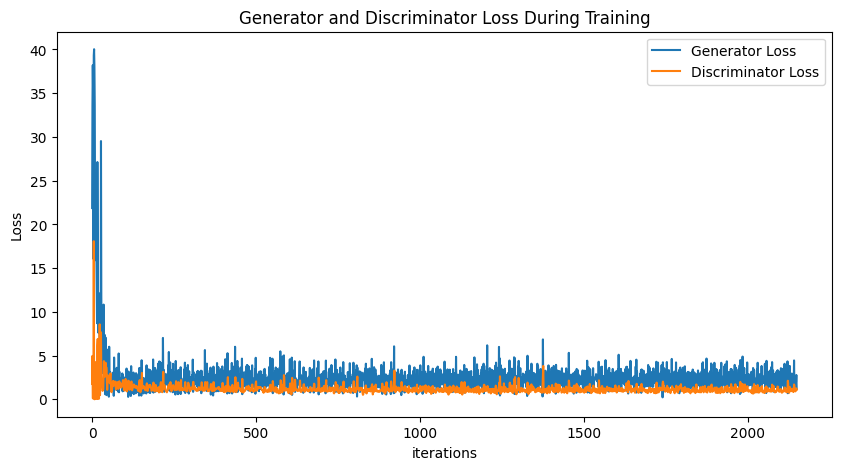

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator Loss")
plt.plot(D_losses,label="Discriminator Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

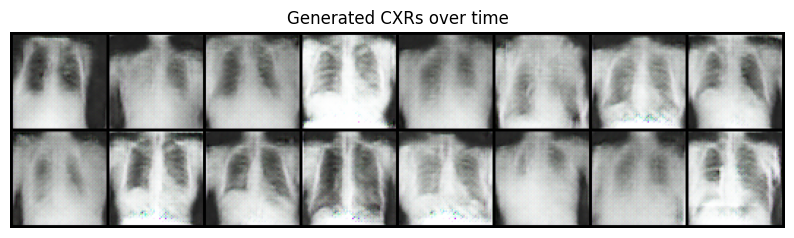

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Generated CXRs over time")

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Load pretrained GANs model

In [ ]:
model = myGenerator(input_size)
model.load_state_dict(torch.load('./GANs.pth'))  #add file path of name of weights
model.eval()

myGenerator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


In [ ]:
model.to(device)
noise_input = torch.randn(5, 16, input_size,1,1 ).to(device)
pred = list()

for vector in noise_input:

  with torch.no_grad():
    fake = model(vector).detach()
    fake = fake.cpu()
  pred.append(vutils.make_grid(fake, padding=2, normalize=True))

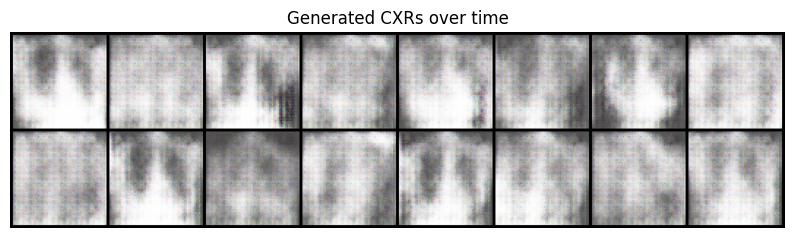

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Generated CXRs over time")

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in pred]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())